In [63]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3qcti59k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3qcti59k
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [64]:
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import torch
from collections import Counter
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import clip
#from google.colab import drive
import os
from os import listdir
from os.path import isfile, join


In [65]:
def find_most_common_answer(answers):
    answer_counter = Counter(answers)
    most_common_answers = answer_counter.most_common()
    most_common_answer, count = most_common_answers[0]
    return most_common_answer

def select_most_common_answers(df):
    selected_answers = []
    for idx, row in df.iterrows():
        answers = [answer["answer"] for answer in row["answers"]]
        selected_answer = find_most_common_answer(answers)

        selected_answers.append({"answer": selected_answer
        })

    # Update the "answer" and "answer_confidence" columns in the DataFrame
    df[["answer"]] = pd.DataFrame(selected_answers)

    return df.drop(["answers"], axis=1)

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_img(path):
    # Load the JPEG image
    image = mpimg.imread(path)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

In [66]:
def dataloader_json(path,test=False):
    # Load the JSON file
    with open(path, 'r') as f:
        data = json.load(f)
    # Create a DataFrame from the loaded JSON data
    df = pd.DataFrame(data)

    if test:
        return df

    return select_most_common_answers(df)

In [67]:
train_df = dataloader_json("dataset/Annotations/Annotations/train.json")

train_df

,image,question,answer_type,answerable,answer
0,VizWiz_train_00000000.jpg,What's the name of this product?,other,1,basil leaves
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,other,1,coca cola
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,other,1,tomatoes
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,other,1,t36m
4,VizWiz_train_00000004.jpg,What is this item?,other,1,solar garden light
...,...,...,...,...,...
20518,VizWiz_train_00023949.jpg,What's the color for this laptop?,other,1,black
20519,VizWiz_train_00023950.jpg,"(inaudible) can you see it? If so, then tell m...",other,1,unanswerable
20520,VizWiz_train_00023951.jpg,What are the three numbers I have to type?,unanswerable,0,unsuitable image
20521,VizWiz_train_00023952.jpg,Is it a box?,yes/no,1,no


In [68]:
train_df['answer'].value_counts()

answer
unanswerable                               3941
unsuitable                                 3038
no                                          567
yes                                         516
white                                       298
                                           ... 
jenny craig florentine breakfast pizzas       1
heads                                         1
sunny paris seasoning                         1
bat                                           1
ipseuri new                                   1
Name: count, Length: 5630, dtype: int64

In [69]:
val_df = dataloader_json("dataset/Annotations/Annotations/val.json")
val_df

,image,question,answer_type,answerable,answer
0,VizWiz_val_00000000.jpg,Ok. There is another picture I hope it is a be...,unanswerable,0,unanswerable
1,VizWiz_val_00000001.jpg,Can you tell me what this medicine is please?,other,1,night time
2,VizWiz_val_00000002.jpg,What is the title of this book?,other,1,dog years
3,VizWiz_val_00000003.jpg,Which one is the blue one?,other,1,right
4,VizWiz_val_00000004.jpg,What does the arrow say?,unanswerable,0,unanswerable
...,...,...,...,...,...
4314,VizWiz_val_00004314.jpg,what is this?,other,1,salad dressing
4315,VizWiz_val_00004315.jpg,Is this modern?,unanswerable,0,unsuitable
4316,VizWiz_val_00004316.jpg,I need to buy this battery for my cordless pho...,unanswerable,0,unanswerable
4317,VizWiz_val_00004317.jpg,What kind of mix is this?,other,1,cake


In [70]:
val_df['answer'].nunique()

1531

In [71]:
data_df = pd.concat((train_df,val_df), axis =0,ignore_index=True)
data_df

,image,question,answer_type,answerable,answer
0,VizWiz_train_00000000.jpg,What's the name of this product?,other,1,basil leaves
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,other,1,coca cola
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,other,1,tomatoes
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,other,1,t36m
4,VizWiz_train_00000004.jpg,What is this item?,other,1,solar garden light
...,...,...,...,...,...
24837,VizWiz_val_00004314.jpg,what is this?,other,1,salad dressing
24838,VizWiz_val_00004315.jpg,Is this modern?,unanswerable,0,unsuitable
24839,VizWiz_val_00004316.jpg,I need to buy this battery for my cordless pho...,unanswerable,0,unanswerable
24840,VizWiz_val_00004317.jpg,What kind of mix is this?,other,1,cake


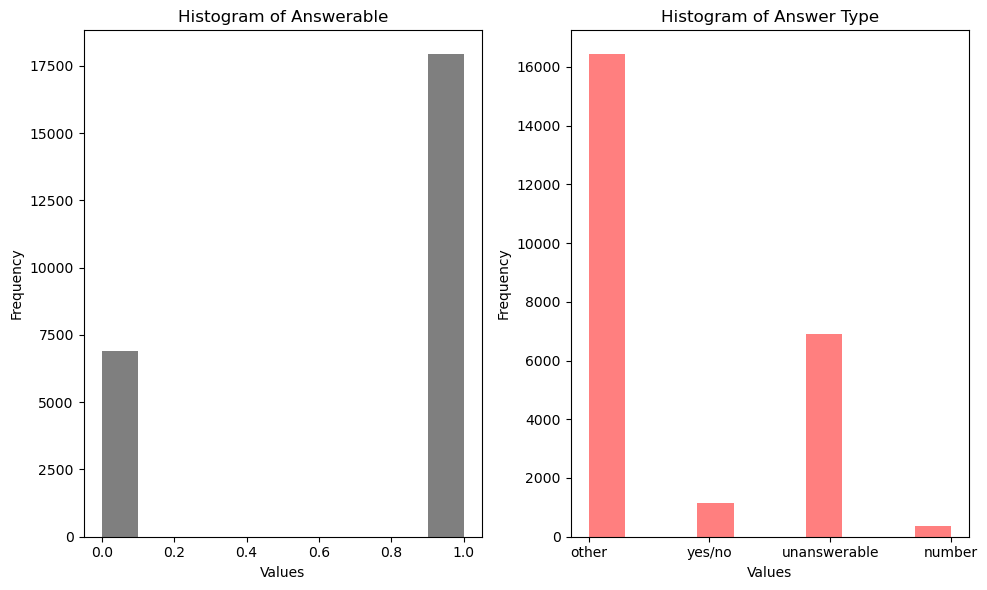

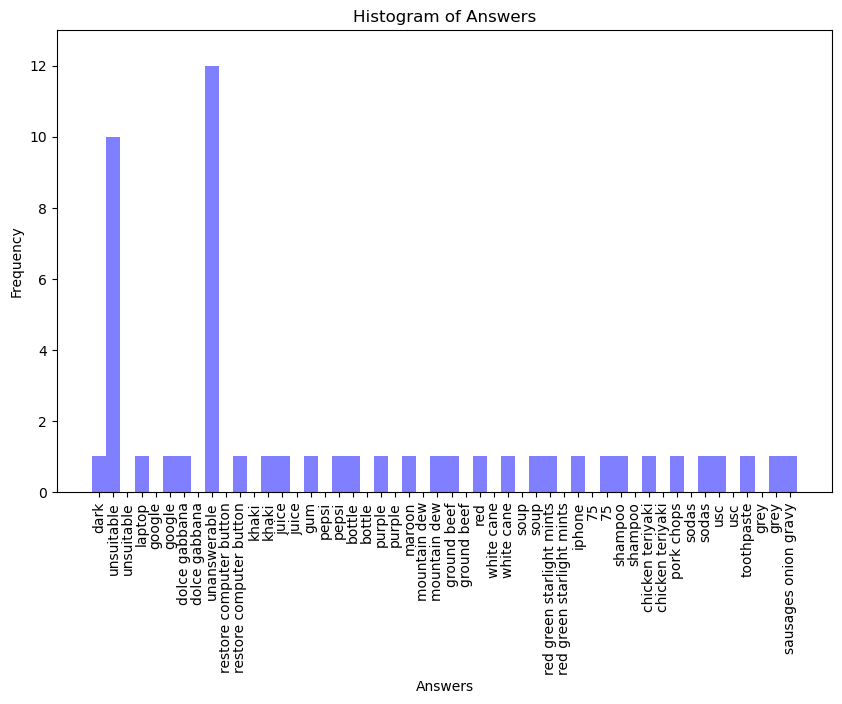

In [74]:

import matplotlib.pyplot as plt
#Create a figure with six subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

# Plot histogram for 'answerable' with a different color
ax1.hist(pd.concat((train_df,val_df),axis = 0)['answerable'], bins=10, alpha=0.5, color='black', align='mid')
ax1.set_title('Histogram of Answerable')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for 'answer_type' with a different color
ax2.hist(pd.concat((train_df,val_df),axis = 0)['answer_type'], bins=10, alpha=0.5, color='red', align='mid')
ax2.set_title('Histogram of Answer Type')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

fig.tight_layout()

# Display the plot
plt.show()

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
counts, bins, patches = plt.hist(data_df.sample(n=50, random_state=42,replace=False)['answer'], bins=50, color='blue', alpha=0.5)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Customize the plot
plt.title('Histogram of Answers')
plt.xlabel('Answers')
plt.ylabel('Frequency')


plt.xticks(rotation=90)

plt.xticks(bin_centers)

max_count = max(counts)
plt.ylim(0, max_count + 1)
# Show the plot
plt.show()

In [75]:
ans_lb = LabelEncoder()
data_df['answer'] = ans_lb.fit_transform(data_df['answer'])
ans_type_lb = LabelEncoder()
data_df['answer_type']= ans_type_lb.fit_transform(data_df['answer_type'])

In [76]:
data_df

,image,question,answer_type,answerable,answer
0,VizWiz_train_00000000.jpg,What's the name of this product?,1,1,768
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,1,1,1727
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,1,1,5885
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,1,1,5694
4,VizWiz_train_00000004.jpg,What is this item?,1,1,5378
...,...,...,...,...,...
24837,VizWiz_val_00004314.jpg,what is this?,1,1,5058
24838,VizWiz_val_00004315.jpg,Is this modern?,2,0,6042
24839,VizWiz_val_00004316.jpg,I need to buy this battery for my cordless pho...,2,0,6033
24840,VizWiz_val_00004317.jpg,What kind of mix is this?,1,1,1269


In [77]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-L/14", device=device)

print(f'Using {device}')

Using cuda


In [14]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
import torch

tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model = OpenAIGPTModel.from_pretrained('openai-gpt')



In [15]:
import torch

encodings = []
encodings2 = []
for img , question in tqdm(zip(data_df['image'],data_df['question'])):
    if "train" in img:

        image = preprocess(Image.open(f'dataset/train/train/{img}').rotate(90)).unsqueeze(0).to(device)
    elif "test" in img:
       image = preprocess(Image.open(f'dataset/test/test/{img}')).unsqueeze(0).to(device)
    else:
        image = preprocess(Image.open(f'dataset/val/val/{img}')).unsqueeze(0).to(device)

    text = clip.tokenize(question).to(device)
    
    with torch.no_grad():
        image_encoding = model_clip.encode_image(image)
        text_encoding = model_clip.encode_text(text)
        
        inputs = tokenizer(question, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        gpt_text=last_hidden_states.numpy().mean(axis=1)
        gpt_text=torch.tensor(gpt_text).to(device)
        fused_text=(gpt_text+text_encoding)/2
        #gpt_text=np.mean(gpt_text)
        #gpt_text=np.delete(gpt_text, -1, axis=1)
        #gpt_text=torch.tensor(gpt_text).to(device)
        
        #gpt_text=gpt_text.reshape(gpt_text.shape[0], (gpt_text.shape[1]*gpt_text.shape[2]))
        #print(gpt_text.shape)
        #print(text_encoding.shape)
        #print(type(text_encoding))
        #print(type(gpt_text))
        #encodings.append(torch.cat([image_encoding, text_encoding,gpt_text], dim=-1))
        #print(img)
        #encodings.append(torch.cat([image_encoding, text_encoding], dim=-1))
        
        encodings.append(torch.cat([image_encoding, fused_text], dim=-1))
        #print(text_encoding.shape)


24842it [49:51,  8.30it/s]


In [16]:
torch.save(encodings,"withgpt.pt")


In [34]:
print(encodings[0].shape[1])
#encodings=torch.load("withgpt.pt")

1536


In [35]:
len(encodings)

24842

In [36]:
print(len(data_df))

24842


In [78]:
# Generate the indices for train-test split
indices = np.arange(20523)

# Perform train-test split
train_indices, test_indices = train_test_split(indices, test_size=0.05, random_state=42, stratify=data_df.iloc[:20523]['answer_type'])
train_indices_aug = train_indices + 20523

In [79]:
train = data_df.iloc[train_indices] 
train = train.reset_index(drop=True)
train

,image,question,answer_type,answerable,answer
0,VizWiz_train_00014709.jpg,What is this?,1,1,5923
1,VizWiz_train_00009566.jpg,What product is this? Is it moisturizing lotion?,1,1,6453
2,VizWiz_train_00011322.jpg,What's in this box?,2,0,6033
3,VizWiz_train_00005267.jpg,What is in this kitchen? In this room?,1,1,2536
4,VizWiz_train_00009281.jpg,Is this shampoo or conditioner?,1,1,5186
...,...,...,...,...,...
19491,VizWiz_train_00015453.jpg,What number is shown?,0,1,233
19492,VizWiz_train_00019967.jpg,Where is B?,1,1,3658
19493,VizWiz_train_00017226.jpg,What kind of tea is this?,1,1,4276
19494,VizWiz_train_00016495.jpg,What is this?,1,1,1650


In [80]:
test = data_df.iloc[test_indices]
test = test.reset_index(drop=True)
test

,image,question,answer_type,answerable,answer
0,VizWiz_train_00023579.jpg,Sometimes they're able to and sometimes they a...,2,0,6033
1,VizWiz_train_00001384.jpg,What is the title of this book? Thank you,2,0,6033
2,VizWiz_train_00015850.jpg,What color is this?,1,1,4565
3,VizWiz_train_00010122.jpg,What's being displayed on my screen?,1,1,402
4,VizWiz_train_00016891.jpg,What is this item?,1,1,2906
...,...,...,...,...,...
1022,VizWiz_train_00010922.jpg,What flavor of kool aid is this?,1,1,5977
1023,VizWiz_train_00017572.jpg,What is this item?,1,1,4891
1024,VizWiz_train_00016464.jpg,What is the name of this book? Thank you.,1,1,3639
1025,VizWiz_train_00001537.jpg,What is this?,1,1,6362


In [81]:
embedding_size = 768#encodings[0].shape[1] #change by Arif old was 768
classes = len(np.unique(ans_lb.classes_))
aux_classes = len(np.unique(train['answer_type']))
BATCH_SIZE = 64

In [82]:
classes, aux_classes

(6503, 4)

In [83]:
encd = torch.cat([torch.load('dataset/encALL.pt')])
                             

In [53]:
type(data_df['answer'])

pandas.core.series.Series

In [55]:
type(encodings)

list

In [84]:
class dataset(Dataset):
    def __init__(self, indices, answers, types, length):
        self.indices = indices
        self.answers = answers
        self.types = types
        self.length = length

    def __getitem__(self, index):
            if self.length <= 20523:
                return encd[self.indices[index]].float() , torch.tensor(int(self.answers[index])), torch.tensor(int(self.types[index]))
            
            return encd[self.indices[index]].float() , torch.tensor(int(self.answers[index % (self.length/2)])), torch.tensor(int(self.types[index % (self.length/2)]))
            
    def __len__(self):
          return self.length

In [85]:
val = data_df.iloc[20523:].reset_index(drop=True)
val
train_indices_aug = train_indices + 20523

In [94]:
e=torch.cat(encodings).cpu().numpy()
#trainDataset = dataset(np.concatenate((train_indices, train_indices_aug)), train['answer'], train['answer_type'], len(train_indices)*2)
trainDataset = dataset(np.concatenate((train_indices, train_indices_aug)), pd.DataFrame(e).iloc[train_indices] , train['answer_type'], len(train_indices)*2)


#valDataset = dataset(np.array(list(range(encd.shape[0] - 4319, encd.shape[0]))), val['answer'], val['answer_type'], 4319)
valDataset = dataset(np.array(list(range(encd.shape[0] - 4319, encd.shape[0]))), pd.DataFrame(e).iloc[20523:], val['answer_type'], 4319)

train_dataloader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=0)

val_dataloader = DataLoader(valDataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=0)

In [95]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1 = nn.LayerNorm(embedding_size*2)
        self.dp1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embedding_size* 2, 512)
        
        self.ln2 = torch.nn.LayerNorm(512)
        self.dp2 = torch.nn.Dropout(0.5)
        
        self.fc2 = torch.nn.Linear(512, classes)
        
        self.fc_aux = torch.nn.Linear(512, aux_classes)
        
        self.lnaux = torch.nn.LayerNorm(aux_classes)
        self.dpaux = torch.nn.Dropout(0.5)
                
        self.fc_gate = torch.nn.Linear(aux_classes, classes)
        self.act_gate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.ln1(x)
        x = self.dp1(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = self.ln2(x)
        x = self.dp2(x)
        
#         aux
        aux = self.fc_aux(x)
#         aux = self.lnaux(aux)
#         aux = self.dpaux(aux)
        
#         linear bottom
        vqa = self.fc2(x)
        
        output = vqa * self.act_gate(self.fc_gate(aux))
        
        
        return output,aux

In [96]:
def run_model(model,dataloader,val_loader, optimizer,train = True ):
    if train:
        model.train()
    
    loss = nn.CrossEntropyLoss()
    
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    total_correct_ty = 0
    total_samples_ty = 0
    
    for (data, ans , ans_type) in tqdm(dataloader):
        data = data.to(device)
        ans = ans.to(device)
        ans_type = ans_type.to(device)
        optimizer.zero_grad()
        output , aux = model(data)
        
        loss_ans = loss(output, ans)
        loss_type = loss(aux,ans_type)
        loss_combined=loss_ans+loss_type
        total_loss += loss_combined.item()
        loss_combined.backward()
        optimizer.step()
        
        
#         Answer Accurracy
        _, predicted_labels = torch.max(output, dim=1)
        correct = (predicted_labels == ans).sum().item()
        total_correct += correct
        total_samples += ans.size(0)
        train_accuracy = total_correct / total_samples
        
#         Type Accuracy
        _, predicted_labels_ty = torch.max(aux, dim=1)
        correct_ty = (predicted_labels_ty == ans_type).sum().item()
        total_correct_ty += correct_ty
        total_samples_ty += ans_type.size(0)
        train_accuracy_ty = total_correct_ty / total_samples_ty
    
    total_train_accuracy = (train_accuracy + train_accuracy_ty) / 2
        
        
    if val_loader is not None:
        model.eval()

    # Initialize validation-specific variables
    val_loss = 0.0
    total_correct_val=0
    total_samples_val=0
    
    total_correct_val_ty=0
    total_samples_val_ty=0
    
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for (data, ans , ans_type) in val_loader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            val_loss += loss_combined.item()

            # Update validation metrics
            _, val_predicted = torch.max(output, dim=1)
            correct_val = (val_predicted == ans).sum().item()
            total_correct_val += correct_val
            total_samples_val += ans.size(0)
            val_accuracy = total_correct_val / total_samples_val
            
            _, val_predicted_ty = torch.max(aux, dim=1)
            correct_val_ty = (val_predicted_ty == ans_type).sum().item()
            total_correct_val_ty += correct_val_ty
            total_samples_val_ty += ans_type.size(0)
            val_accuracy_ty = total_correct_val_ty / total_samples_val_ty
        
        total_val_accuracy = (val_accuracy + val_accuracy_ty) / 2
        
    train_loss = total_loss/len(dataloader)
    val_loss = val_loss/len(val_loader)
    
    print(f"\nTrain Loss: {train_loss:.4f} | AVG Train ACC: {total_train_accuracy * 100:.4f}% | Val Loss: {val_loss:.4f} | AVG Val ACC: {total_val_accuracy * 100:.2f}%")
    
    print(f"\nTrain ANS ACC: {train_accuracy * 100:.4f}% | VAL ANS ACC: {val_accuracy * 100:.4f}% | Train TYPE ACC: {train_accuracy_ty * 100:.4f}% | VAL TYPE ACC: {val_accuracy_ty * 100:.2f}%\n")
        
    return train_loss, val_loss


In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)
model = nn.DataParallel(model)

epoch = 125
training_loss = []
val_loss = []

optimizer = torch.optim.Adam(model.parameters(),1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.1, threshold=1e-6)

early_stopping_patience = 15  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

for e in range(epoch):
    print(f'Epoch: {e+1}', f'| LR: { optimizer.param_groups[0]["lr"] }')
    trLoss, vlLoss = run_model(model,train_dataloader,val_dataloader,optimizer)    
    training_loss.append(trLoss)
    val_loss.append(vlLoss)
    
    scheduler.step(vlLoss)
    
    # Check if validation loss has improved
    if vlLoss < best_val_loss:
        best_val_loss = vlLoss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Check if early stopping criteria met
    if epochs_without_improvement >= early_stopping_patience:
        print(f"\nValidation loss hasn't improved for {early_stopping_patience} epochs. Early stopping.")
        break

Epoch: 1 | LR: 0.001


  0%|                                                   | 0/610 [00:00<?, ?it/s]


KeyError: 17672.0

In [32]:
testDataset = dataset(test_indices,test['answer'], test['answer_type'],1027)
test_dataloader = DataLoader(testDataset, batch_size=BATCH_SIZE , shuffle=True, num_workers=0)

In [33]:
loss = nn.CrossEntropyLoss()
model.eval()
test_loss = 0.0
total_correct_test=0
total_samples_test=0
    
total_correct_test_ty=0
total_samples_test_ty=0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the validation data
    for (data, ans , ans_type) in test_dataloader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            test_loss += loss_combined.item()

            # Update validation metrics
            _, test_predicted = torch.max(output, dim=1)
            correct_test = (test_predicted == ans).sum().item()
            total_correct_test += correct_test
            total_samples_test += ans.size(0)
            test_accuracy = total_correct_test / total_samples_test
            
            _, test_predicted_ty = torch.max(aux, dim=1)
            correct_test_ty = (test_predicted_ty == ans_type).sum().item()
            total_correct_test_ty += correct_test_ty
            total_samples_test_ty += ans_type.size(0)
            test_accuracy_ty = total_correct_test_ty / total_samples_test_ty
        
    total_test_accuracy = (test_accuracy + test_accuracy_ty) / 2
        
        
print(f"Test TYPE ACC: {test_accuracy_ty * 100:.4f}% | Test ANS ACC: {test_accuracy * 100:.4f}% | AVG Test ACC: {total_test_accuracy * 100:.4f}% | Test Loss: {test_loss:.4f}")   

Test TYPE ACC: 81.4995% | Test ANS ACC: 40.9932% | AVG Test ACC: 61.2463% | Test Loss: 131.1630
